In [2]:
# loading all necessary libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sklearn
import seaborn as sns
# Natural Language Processing (NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Text Vectorization and Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
)
from xgboost import XGBClassifier

/tmp/ipykernel_1110/234385443.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# loading the data
with open('tagged_intent_data.json', 'r') as file:
    intents = json.load(file)

def pair_questions_responses(data):
    paired_data = []
    for sublist in data:  # If data is a list of lists
        for item in sublist:  # Assuming each sublist contains dictionaries
            tag = item.get('tag', [])
            questions = item.get('questions', [])
            responses = item.get('responses', [])
            
            for question, response in zip(questions, responses):
                paired_data.append({'tag': tag, 'question': question, 'response': response})
    
    return paired_data

# Use the function to pair questions and responses
paired_data = pair_questions_responses(intents)
df = pd.DataFrame(paired_data)
df.head(5)

,tag,question,response
0,Personal Care,can i put this on a toddler skin?,Homedics has a complete list of instruction ma...
1,Personal Care,Does VANICREAM Mositurizing Skin Cream contain...,I leave the unit on all the time so it is alwa...
2,Personal Care,Does it work for UV gel nail polish? It came u...,"It came with the proper amount of wax, but thi..."
3,Personal Care,Does your skin gets darker before it peels?,The expiration date is on the bottom of the pl...
4,Personal Care,"Can this be used on neck, chest and hands too ...",This product is awesome. I dont spend a lot of...


The output shows that questions and responses are successfully paired with their corresponding tags. The Personal Care tag, for instance, includes various questions about product usage, indicating a successful parsing and pairing of data.

In [7]:
# Adjusted list comprehension for nested structure
normalized_questions = [question.lower() for sublist in intents for item in sublist for question in item['questions']]
# Removing punctuation and special characters
import re
cleaned_questions = [re.sub(r'[^\w\s]', '', question) for question in normalized_questions]
print("Cleaned Questions (Sample):", cleaned_questions[:5])



Cleaned Questions (Sample): ['can i put this on a toddler skin', 'does vanicream mositurizing skin cream contain urea and what percentage', 'does it work for uv gel nail polish it came up in that search', 'does your skin gets darker before it peels', 'can this be used on neck chest and hands too or am i better off using a lower 5 solution for aging skin on those areas']


This process has effectively cleaned and prepares text data for analysis. The cleaned and filtered words indicate a focus on relevant keywords, which is essential for understanding and classifying user queries.

In [9]:
# Tokenization: Break text into words
tokenized_questions = [question.split() for question in cleaned_questions]
# Display the first few tokenized questions
print("Tokenized Questions (Sample):", tokenized_questions[:5])

Tokenized Questions (Sample): [['can', 'i', 'put', 'this', 'on', 'a', 'toddler', 'skin'], ['does', 'vanicream', 'mositurizing', 'skin', 'cream', 'contain', 'urea', 'and', 'what', 'percentage'], ['does', 'it', 'work', 'for', 'uv', 'gel', 'nail', 'polish', 'it', 'came', 'up', 'in', 'that', 'search'], ['does', 'your', 'skin', 'gets', 'darker', 'before', 'it', 'peels'], ['can', 'this', 'be', 'used', 'on', 'neck', 'chest', 'and', 'hands', 'too', 'or', 'am', 'i', 'better', 'off', 'using', 'a', 'lower', '5', 'solution', 'for', 'aging', 'skin', 'on', 'those', 'areas']]


In [11]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:

# Stop words removal
stop_words = set(stopwords.words('english'))
filtered_words = [[word for word in question if word not in stop_words] for question in tokenized_questions]
# Display the first few sets of filtered words
print("Filtered Words (Sample):", filtered_words[:5])

Filtered Words (Sample): [['put', 'toddler', 'skin'], ['vanicream', 'mositurizing', 'skin', 'cream', 'contain', 'urea', 'percentage'], ['work', 'uv', 'gel', 'nail', 'polish', 'came', 'search'], ['skin', 'gets', 'darker', 'peels'], ['used', 'neck', 'chest', 'hands', 'better', 'using', 'lower', '5', 'solution', 'aging', 'skin', 'areas']]


In [13]:

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer() 
lemmatized_words = [[lemmatizer.lemmatize(word) for word in question] for question in filtered_words]

print("Lemmatized Words (Sample):", lemmatized_words[:5])


[nltk_data] Downloading package wordnet to /home/gitpod/nltk_data...


Lemmatized Words (Sample): [['put', 'toddler', 'skin'], ['vanicream', 'mositurizing', 'skin', 'cream', 'contain', 'urea', 'percentage'], ['work', 'uv', 'gel', 'nail', 'polish', 'came', 'search'], ['skin', 'get', 'darker', 'peel'], ['used', 'neck', 'chest', 'hand', 'better', 'using', 'lower', '5', 'solution', 'aging', 'skin', 'area']]


In [14]:

import statistics

# Adjusting to the nested list structure of intents
flat_intents = [item for sublist in intents for item in sublist]  # Flatten the list of lists to a simple list of dictionaries

# Compute statistics
intent_counts = {item['tag']: len(item['questions']) for item in flat_intents}

# Calculate additional statistics
mean_questions_per_intent = statistics.mean(intent_counts.values())
median_questions_per_intent = statistics.median(intent_counts.values())
total_intents = len(intent_counts)

# Find the intent(s) with the fewest questions
min_questions_count = min(intent_counts.values())
intents_with_fewest_questions = [intent for intent, count in intent_counts.items() if count == min_questions_count]

# Print the calculated statistics
print(f"Total Intents: {total_intents}")
print(f"Mean Questions per Intent: {mean_questions_per_intent:.2f}")
print(f"Median Questions per Intent: {median_questions_per_intent}")
print(f"Intent(s) with Fewest Questions ({min_questions_count} questions): {', '.join(intents_with_fewest_questions)}")


Total Intents: 12
Mean Questions per Intent: 1151.92
Median Questions per Intent: 475.0
Intent(s) with Fewest Questions (75 questions): Health and Safety


The analysis reveals the dataset's composition, such as the total number of intents, average questions per intent, and identifies intents with fewer questions. This insight guide further data collection or adjustment to ensure a balanced dataset.

In [15]:
# loading data
with open('tagged_intent_data.json', 'r') as f:
    data = json.load(f)

# Flatten the data if it's nested (list of lists of dictionaries)
flat_data = [item for sublist in data for item in sublist]

# Replacing "answers" with "responses" if needed
for entry in flat_data:
    if "answers" in entry:
        entry["responses"] = entry.pop("answers")

intents_dict = {"QnA": [], "tags": []}

for intent in flat_data:
    # Extract questions and tag
    for question in intent.get("questions", []):
        intents_dict["tags"].append(intent["tag"])
        intents_dict["QnA"].append(question)
    # Extract responses and tag
    for res in intent.get("responses", []):
        intents_dict["tags"].append(intent["tag"])
        intents_dict["QnA"].append(res)

df = pd.DataFrame(intents_dict, columns=["QnA", "tags"])

# Set seed to ensure reproducibility when shuffling
np.random.seed(42)
# Shuffle to reduce bias and improve generalization
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,QnA,tags
0,Yes,Product Authenticity
1,No,Health and Safety
2,No,Ingredient Specific Questions
3,Not to my knowledge but it is a great setter.,Product Comparison
4,I dont know what the warranty it has. Its bee...,Shipping and Packaging


## Text Preprocessing and Model Training Preparation

In [16]:
# Text Preprocessing
# Text Cleaning: convert to lower case and remove non-alphanumeric characters
df['QnA'] = df['QnA'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)

# Tokenization
df['QnA'] = df['QnA'].apply(word_tokenize)

# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['QnA'] = df['QnA'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['QnA'] = df['QnA'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Joining tokens back into a string
df['QnA'] = df['QnA'].apply(lambda x: ' '.join(x))


## Train-Test Split and Vectorization

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['QnA'], df['tags'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

These steps are crucial for converting text into a format that machine learning models can process. The use of TF-IDF vectorization helps in highlighting the importance of words in relation to their frequency in the dataset and the corpus.

In [18]:
# !pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [19]:
# Oversample the training data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

# Data preprocessing and encoding
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the oversampled target variable
ohe = OneHotEncoder()
y_resampled_encoded = ohe.fit_transform(pd.DataFrame(y_resampled).values.reshape(-1, 1))
from imblearn.over_sampling import RandomOverSampler

Oversampling and encoding ensured that the model does not bias towards majority class and can distinguish between classes effectively. TF-IDF vectorization transformed text into informative numerical features.

In [20]:
# Oversample the training data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

# Data preprocessing and encoding
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the oversampled target variable
ohe = OneHotEncoder()
y_resampled_encoded = ohe.fit_transform(pd.DataFrame(y_resampled).values.reshape(-1, 1))

To deal with the unequal class proportions in the training set, we applied oversampling (RandomOverSampler) technique. This ensured that the model did not favor the dominant class over the minority class. 

We also used TF-IDF vectorization to transform the text data into numerical features. Additionally, we performed one-hot encoding on the oversampled target variable to create dummy variables for each class.

In [21]:
print(df['tags'].value_counts())

tags
Personal Care                    38014
Usage Instructions               36453
Product Comparison               34240
Shipping and Packaging           34189
Product Authenticity             33675
Fragrance                        33436
Electronics                      33386
Accessories and Attachments      33279
Ingredient Specific Questions    33164
Warranty and Customer Support    33158
International Shipping           33050
Health and Safety                33011
Name: count, dtype: int64


In [22]:
print(df['tags'].value_counts())

print(y_train.value_counts())
print(y_test.value_counts())


tags
Personal Care                    38014
Usage Instructions               36453
Product Comparison               34240
Shipping and Packaging           34189
Product Authenticity             33675
Fragrance                        33436
Electronics                      33386
Accessories and Attachments      33279
Ingredient Specific Questions    33164
Warranty and Customer Support    33158
International Shipping           33050
Health and Safety                33011
Name: count, dtype: int64
tags
Personal Care                    30410
Usage Instructions               29060
Product Comparison               27505
Shipping and Packaging           27385
Fragrance                        26951
Product Authenticity             26897
Electronics                      26663
Accessories and Attachments      26575
Warranty and Customer Support    26511
Ingredient Specific Questions    26500
Health and Safety                26408
International Shipping           26379
Name: count, dtype: int64
ta

In [23]:
print(pd.Series(y_resampled).value_counts())

tags
Electronics                      30410
International Shipping           30410
Usage Instructions               30410
Fragrance                        30410
Product Comparison               30410
Product Authenticity             30410
Ingredient Specific Questions    30410
Warranty and Customer Support    30410
Health and Safety                30410
Accessories and Attachments      30410
Personal Care                    30410
Shipping and Packaging           30410
Name: count, dtype: int64


This gives an overview of the number of examples per intent/tag in the dataset. Helps identify class imbalance issues.

## Multinomial Naive Bayes Model

In [24]:
# Train a multinomial model
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)

MultinomialNB()

In [26]:
# Make predictions
predictions = nb_model.predict(X_test_tfidf)
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))
# Evaluate the model on the test set
accuracy = nb_model.score(X_test_tfidf, y_test)


Accuracy: 0.06140983486328244
Classification Report:
                                precision    recall  f1-score   support

  Accessories and Attachments       0.05      0.05      0.05      6704
                  Electronics       0.05      0.04      0.04      6723
                    Fragrance       0.04      0.03      0.04      6485
            Health and Safety       0.02      0.01      0.02      6603
Ingredient Specific Questions       0.03      0.02      0.03      6664
       International Shipping       0.03      0.02      0.03      6671
                Personal Care       0.12      0.20      0.15      7604
         Product Authenticity       0.05      0.03      0.04      6778
           Product Comparison       0.07      0.06      0.06      6735
       Shipping and Packaging       0.07      0.07      0.07      6804
           Usage Instructions       0.10      0.10      0.10      7393
Warranty and Customer Support       0.04      0.06      0.05      6647

                     

In [27]:
print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.06


MultinomialNB model makes an independence assumption and suits discrete data. Low accuracy indicates it did not generalize well.


Evaluation:

The multinomial Naive Bayes model achieved a low accuracy of 0.06 on the test set, indicating poor generalization capability.

Diving into the classification report, we observe very low scores across all the intent classes. The macro average precision is 0.05, recall is 0.06 and F1 is 0.06, highlighting that the model struggled to correctly classify examples from the minority classes.

Most classes have precision and recall scores in the 0.02 to 0.07 range, with just the "Personal Care" intent slightly higher at 0.12 precision and 0.20 recall. Such large class imbalances showcase the model's inability to learn effectively from skewed datasets.

The model's average cross-validation accuracy over 5 folds is 0.07, which aligns with the low test accuracy. This confirms the model's subpar performance irrespective of train-test split.




In [28]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb_model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.07182396 0.07228982 0.07205689 0.0704812  0.07178286]
Mean Accuracy: 0.07168694508385401


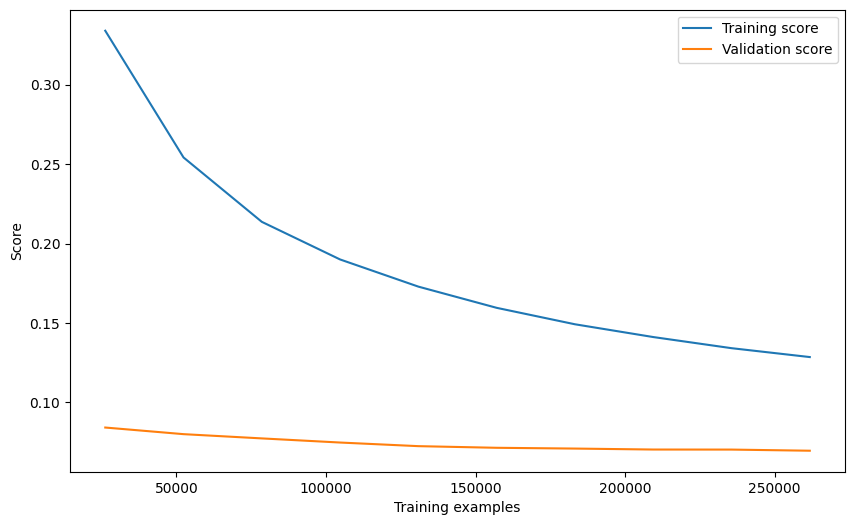

In [29]:
# Learning Curve
from sklearn.model_selection import learning_curve

# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()
## Multinomial Naive BAYES' model's Hyperparameter Tuning
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()


In [30]:
# Fit the TF-IDF Vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Get the feature names after fitting the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Combine the oversampled training data and labels
resampled_data = pd.DataFrame(X_resampled.toarray(), columns=feature_names)
resampled_data['tags'] = y_resampled


In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from sklearn.utils import resample

In [32]:
# A smaller subset of data; the dataset is very large
# Resampled_data is our DataFrame and it's large

sample_size = 100000  # Adjust this number based on your computational resources
subset_data = resample(resampled_data, n_samples=sample_size, random_state=42, replace=False)

# Separate features and target variable from the subset
X_subset = subset_data.drop('tags', axis=1)
y_subset = subset_data['tags']

In [33]:
# Define a smaller or more focused parameter grid
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0]}


In [34]:
# Initialize RandomizedSearchCV with fewer iterations for quicker results
# Use a conservative number of jobs to avoid overloading the system
random_search_nb = RandomizedSearchCV(nb_model, param_distributions=param_grid_nb, n_iter=4, cv=5, scoring='accuracy', random_state=42, n_jobs=2)  # Adjust n_jobs based on your system

In [35]:
# Perform the search on the subset of data
random_search_nb.fit(X_subset, y_subset)

# Print the best parameters and the corresponding accuracy
print("Best Parameters for Multinomial Naive Bayes:", random_search_nb.best_params_)
print("Best Accuracy on Validation Set:", random_search_nb.best_score_)


Best Parameters for Multinomial Naive Bayes: {'alpha': 2.0}
Best Accuracy on Validation Set: 0.08051


In [36]:
# If your test set is also large and needs to be sampled:
test_sample_size = 20000  # Adjust as per your computational resources and needs
X_test_subset, y_test_subset = resample(X_test, y_test, n_samples=test_sample_size, random_state=42, replace=False)

# Preprocess X_test_subset similarly to X_train (e.g., lowercasing, removing non-alphanumeric characters, etc.)
# X_test has already been preprocessed similarly to X_train, so we directly transform it using TF-IDF vectorizer
X_test_subset_tfidf = tfidf_vectorizer.transform(X_test_subset)

In [37]:
# Now you can proceed with making predictions and evaluating the model as before
y_pred_subset = random_search_nb.predict(X_test_subset_tfidf)

# Calculate accuracy on the test subset
accuracy_test = accuracy_score(y_test_subset, y_pred_subset)
print(f"Accuracy on the test set: {accuracy_test:.2f}")

# For cross-validation scores
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(random_search_nb.best_estimator_, X_subset, y_subset, cv=cv, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

/home/gitpod/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


Accuracy on the test set: 0.07
Cross-Validation Scores: [0.08075 0.0766  0.0801  0.0821  0.0793 ]
Mean Accuracy: 0.07977


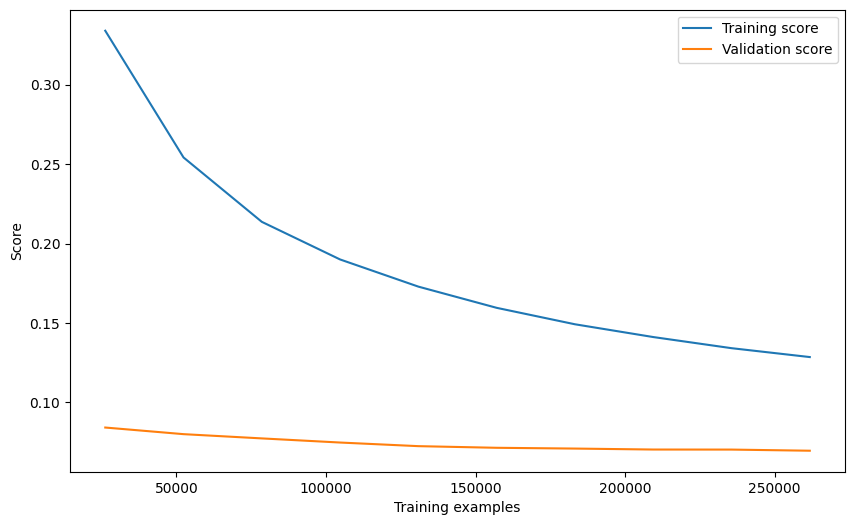

In [104]:
# Learning Curve
from sklearn.model_selection import learning_curve

# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

## Multinomial Naive BAYES' model's Hyperparameter Tuning

In [39]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the TF-IDF Vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Get the feature names after fitting the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Combine the oversampled training data and labels
resampled_data = pd.DataFrame(X_resampled.toarray(), columns=feature_names)
resampled_data['tags'] = y_resampled

## Further Hyperparameter Tuning Using RandomizedSearchCV

First, we define a pipeline that includes both TfidfVectorizer for text vectorization and MultinomialNB as the classifier.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])


Then we define the Parameter Distributions. Instead of a grid of parameters (as in GridSearchCV), with RandomizedSearchCV, we define distributions from which values will be randomly sampled.

In [41]:
param_distributions = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': [True, False],
    'nb__alpha': [0.01, 0.1, 1.0, 10.0]
}



Initializing RandomizedSearchCV with the pipeline and the parameter distributions. We can specify the number of parameter settings to sample with n_iter. Additionally, we can use cross-validation (e.g., cv=5) for evaluation.

In [103]:


random_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)


In [107]:
# Fit the RandomizedSearchCV instance to your training data.
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END nb__alpha=10.0, tfidf__max_df=1.0, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__use_idf=False; total time=  19.3s
[CV] END nb__alpha=1.0, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=  18.2s
[CV] END nb__alpha=1.0, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=  18.1s
[CV] END nb__alpha=1.0, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=  17.8s
[CV] END nb__alpha=1.0, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=  18.2s
[CV] END nb__alpha=1.0, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1), tfidf__use_idf=True; total time=  18.5s
[CV] END nb__alpha=10.0, tfidf__max_df=1.0, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__use_idf=False; total time=  33.6s
[CV] END nb__alpha=10.0, tfidf__max_df=1.

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('nb', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'nb__alpha': [0.01, 0.1, 1.0, 10.0],
                                        'tfidf__max_df': [0.5, 0.75, 1.0],
                                        'tfidf__min_df': [1, 2, 5],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)],
                                        'tfidf__use_idf': [True, False]},
                   random_state=42, verbose=2)

In [105]:
def preprocess_text(texts):
    # Example preprocessing steps
    processed_texts = [text.lower() for text in texts]  # Lowercasing
  
    return processed_texts
